In [1]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
import scanpy as sc
import anndata
import pandas as pd
import tools
import logging
import mira
import warnings

import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

warnings.filterwarnings('ignore')

/home/haiyi/anaconda3/envs/halo2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
atac_model = mira.topics.AccessibilityTopicModel(counts_layer='counts',
                                                 dataset_loader_workers = 3)

rna_model = mira.topics.ExpressionTopicModel(
    endogenous_key='endog',
    exogenous_key='endog',
    counts_layer='counts',
    seed = 0,
    hidden=64, # to make the tutorial faster. In practice, use the default of 128!
)          


rna_model = mira.topics.ExpressionTopicModel.load('MIRA/hair_rna_topic_model.pth')
atac_model = mira.topics.AccessibilityTopicModel.load('MIRA/hair_atac_topic_model.pth')

rna_data = sc.read_h5ad("data/datasets/mouse_hair_mira_rna.h5ad")
atac_data = sc.read_h5ad("data/datasets/mouse_hair_mira_atac.h5ad")

rna_data.var.index = rna_data.var.index.str.upper()
rp_args = dict(expr_adata = rna_data, atac_adata= atac_data)
rp_genes = list(rna_model.features[rna_model.highly_variable])
rp_genes = [str(e).upper() for e in rp_genes]
lgenes = ['Gna12', 'Dmpk', 'Ubtf', 'Nfe2l3', 'Cspp1', 'Wdr47', 'Ptpra', 'Mfsd2a',
       'Nedd9', 'Lrp4', 'Myo9a', 'Tfap2b', 'Zfand5', 'Hs3st3b1', 'Orc1',
       'Inpp5f', 'Lama5', 'Akap10', 'Mylk', 'Heg1', 'Agl', 'Safb2', 'Brd9',
       'Rnf180', 'Itgb5', 'Bmp2k', 'Fnbp1l', 'Cpt1a', 'Ccnt1', 'Slc7a6'] + ['Mt2', 'Braf', 'Slc4a7', 'Lonrf3', 'Fam126b', 'Gpatch1',
       'Sdf4', 'Cers4', 'R3hdm2', 'Nbea', 'Rnf10', 'Ppp1r14c', 'Kremen1',
       'Nav2', '5031439G07Rik', 'Ythdf1', 'Galnt3', 'Setd7', 'Spata5',
       'Arhgef10l', 'Cep128', 'Ltbp3', 'Ranbp1', 'Atg7', 'Tcf3', 'Ddx52',
       'BC005561', 'Psrc1', 'Chd3']
irs_genes = [ "GATA3", "WNT3"]       
lgenes = [str(e).upper() for e in lgenes]

rp_genes = rp_genes + lgenes + irs_genes

litemodel = mira.rp.LITE_Model(expr_model = rna_model,
                              accessibility_model=atac_model,
                              counts_layer='counts',
                              genes = rp_genes)

litemodel.load("rpmodels/hair/")

rna_data.var.index = rna_data.var.index.str.upper()
rna_data.obs["latent_time_cat"] = pd.cut(rna_data.obs['latent_time'], 20, labels=[str(i) for i in range(20)])
rna_data.obs["latent_time_2"] = pd.cut(rna_data.obs['latent_time'], 50, labels=[str(i) for i in range(50)])
rna_data.obs["latent_time_10"] = pd.cut(rna_data.obs['latent_time'], 10, labels=[str(i) for i in range(10)])
rna_data.obs["latent_time_3"] = pd.cut(rna_data.obs['latent_time'], 5, labels=[str(i) for i in range(5)])
rna_data.obs["latent_time_8"] = pd.cut(rna_data.obs['latent_time'], 8, labels=[str(i) for i in range(8)])
rna_data.obs["latent_time_6"] = pd.cut(rna_data.obs['latent_time'], 6, labels=[str(i) for i in range(6)])

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [3]:
rna_norm = sc.read_h5ad("data/datasets/mouse_hair_mira_rna_norm.h5ad")
atac_norm = sc.read_h5ad("data/datasets/mouse_hair_mira_atac_norm.h5ad")
rna_data = sc.read_h5ad("data/datasets/mouse_hair_rna_paired.h5ad")

rna_data.layers["norm"] = rna_norm.layers["norm"] 
atac_data.layers["norm"] = atac_norm.layers["norm"] *1e4
norm_X = atac_norm.layers["norm"]


In [13]:
atac_data.var

,feature_types,modality,n_cells,chr,start,end
Id,,,,,,
0,Peaks,Peaks,4078,chrX,143482906,143483206
1,Peaks,Peaks,4088,chr6,3200976,3201276
2,Peaks,Peaks,2032,chr9,123461850,123462150
3,Peaks,Peaks,2082,chr1,56782095,56782395
4,Peaks,Peaks,1850,chr9,56223668,56223968
...,...,...,...,...,...,...
344411,Peaks,Peaks,73,chr10,81232540,81232840
344496,Peaks,Peaks,78,chr10,3862097,3862397
344514,Peaks,Peaks,94,chr10,24784301,24784601


In [4]:
def aggregate_local_atac(table, norm_X, atac_data):
    indices = table.index.to_numpy()
    col_index = [atac_data.var.index.get_loc(e) for e in indices]
    gene_peaks = norm_X[:, col_index]
    gene_peaks = np.sum(gene_peaks, axis=1)
    
    return gene_peaks

def get_gene_local_atac(genename, litemodel, rna_data, atac_data, norm_X, decay_period=100):
    table = litemodel[genename].get_influential_local_peaks(atac_data, decay_periods = decay_period)
    peaks = aggregate_local_atac(table, norm_X,atac_data)
    rna_data.obs["local_peaks"] = peaks

def get_gene_local_atac_mtx(genenames, litemodel, rna_data, atac_data, norm_X, decay_period=100):
    for genename in genenames:
        table = litemodel[genename].get_influential_local_peaks(atac_data, decay_periods = decay_period)
        peaks = aggregate_local_atac(table, norm_X)
        name = genename+"local_peaks"
        rna_data.obs[name] = peaks

from scipy.sparse import csr_matrix
def get_peaks(rna_data, atac_data, litemodel, decay_period=100):
    norm_X = atac_data.layers["norm"]
    cellnum =rna_data.shape[0]
    genenames = rna_data.var.index.tolist()
    peaks = []
    for gene in genenames:
        try:
            table = litemodel[gene].get_influential_local_peaks(atac_data, decay_periods = decay_period)
            peak = aggregate_local_atac(table, norm_X, atac_data)
        except:
            peak = [0]*cellnum
        peaks.append(peak)
    peaks  = np.array(peaks).transpose()
    print(np.array(peaks).shape)
    peaks = csr_matrix(peaks)
    rna_data.layers["peaks"] = peaks         


def get_gene_peaks(gene, atac_data, litemodel, decay_period=100):
    norm_X = atac_data.layers["norm"]
    cellnum =rna_data.shape[0]
    peaks = []
    try:
        table = litemodel[gene].get_influential_local_peaks(atac_data, decay_periods = decay_period)
        peaks = atac_data[:, table.index].layers["norm"]
        return peaks, table.index
    except:
        print("no such genes")



In [5]:
## get the influenced the genes 
decay_period = 100

def get_influenced_genes(genelist, atac_data, gene1, litemodel, decay_period=100):
    
    table_gene = litemodel[gene1].get_influential_local_peaks(atac_data, decay_periods = decay_period)
    # lowerbound = table_gene.start.min() - 50e4
    # upperbound = table_gene.end.max() + 50e4
    lowerbound = table_gene.start.min()
    upperbound = table_gene.end.max()
    chrom = table_gene.chr[0]
    fetched_genes = fetch_influenced_gene_region(genelist, gene1, atac_data, lowerbound, upperbound, chrom, litemodel)
    return fetched_genes

def fetch_influenced_gene_region(genelist, gene1, atac_data, lowerbound, upperbound, chrom, litemodel, decay_period=100):
    fetched_genes = []
    for gene in genelist:
        if gene == gene1:
            continue
        table = litemodel[gene].get_influential_local_peaks(atac_data, decay_periods = decay_period)
        try:
            if table.chr[0] != chrom:
                continue 
            lowerbound0 = table.start.min() 
            upperbound0 = table.end.max()
            
            if lowerbound0 >= lowerbound and lowerbound0 < upperbound:
                fetched_genes.append(gene)
            elif     upperbound0 <= upperbound and lowerbound < upperbound0:
                fetched_genes.append(gene)
        except:
            print(gene)        

    return fetched_genes


def get_influenced_genes_chroms(genelist, atac_data, gene1, litemodel):
    table_gene = litemodel[gene1].get_influential_local_peaks(atac_data)
    chrom = table_gene.chr[0]
    fetched_genes = []
    for gene in genelist:
        if gene == gene1:
            continue
        table2 = litemodel[gene].get_influential_local_peaks(atac_data)
        try:
            chrom2 = table2.chr[0]
            if chrom2 == chrom:
                fetched_genes.append(gene)
        except:
            print(gene)        
    return fetched_genes


In [6]:
def get_gene_peak_timeseries_pairs(gene, genelist, atac_data, rna_data, litemodel, decay_period_g=100, decay_period_p=1, time="latent_time_8"):
    ### get the dataframe includes potential granger causal peaks and 
    ###  influenced genes and their gene expression marked with time stamps
    influenced_genes = get_influenced_genes(genelist, atac_data, gene, litemodel, decay_period=decay_period_g)
    effect_expr = rna_data[:, influenced_genes].layers["norm"]
    # print(effect_expr.shape)
    # gene_table = pd.DataFrame(dict(map(lambda i,j : (i,j) , influenced_genes, effect_expr)))
    causal_peaks, peak_ids =  get_gene_peaks(gene, atac_data, litemodel, decay_period=decay_period_p)
    sum_peaks = np.sum(causal_peaks, axis=1)
    # print(causal_peaks.shape)
    keys = np.concatenate([influenced_genes, peak_ids])
    values = np.concatenate([effect_expr, causal_peaks], axis=1)
    granger_table = pd.DataFrame(values, columns=keys)
    granger_table["peak_sum"] = sum_peaks
    granger_table[time] = rna_data.obs[time].to_numpy()
    granger_table = granger_table.sort_values(time)
    
    return granger_table



In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_granger_pvalue(gc_res, timerange,save=False, s=50):
    lrtest = []
    ftest = []
    chi2test = []
    fparam = []
    for time in timerange:
        lrtest.append(-np.log10(gc_res[time][0]["lrtest"][1]))
        ftest.append(-np.log10(gc_res[time][0]["ssr_ftest"][1]))
        chi2test.append(-np.log10(gc_res[time][0]["ssr_chi2test"][1]))
        fparam.append(-np.log10(gc_res[time][0]["params_ftest"][1]))
    tests = pd.DataFrame({"lrtest": lrtest, "ssr_ftest":ftest, "ssr_chi2test":chi2test, "params_ftest":fparam, "time_lag":timerange})
    pvalue_melt = pd.melt(tests, id_vars=["time_lag"], 
    value_vars=["lrtest", "ssr_ftest","ssr_chi2test", "params_ftest"])
    g = sns.FacetGrid(pvalue_melt, col="variable", hue="variable", col_wrap=4, height=4, aspect =1, palette="dark")
    g.map(sns.scatterplot, "time_lag", "value", alpha=.7, s=s, edgecolors=None,linewidth=0)
    # g.map(sns.lineplot, "time_lag", "value", alpha=.7, linewidth=s,markers="o")

    for ax in g.axes_dict.values():
        ax.axline((0, 3), slope=0, c=".2", ls="--", zorder=0,)
    for ax in g.axes_dict.values():
        ax.vlines(x = timerange[0], ymin=0, ymax=20,  color= 'tab:blue', ls="--")    
    g.add_legend()
    if save:
        plt.savefig(save, dpi=600)

    return tests   
    


def plot_granger_pvalue_lt(gc_res, timerange,save=False, s=50):
    lrtest = []
    ftest = []
    chi2test = []
    fparam = []
    for time in timerange:
        lrtest.append(-np.log10(gc_res[time][0]["lrtest"][1]))
        # ftest.append(-np.log10(gc_res[time][0]["ssr_ftest"][1]))
        # chi2test.append(-np.log10(gc_res[time][0]["ssr_chi2test"][1]))
        # fparam.append(-np.log10(gc_res[time][0]["params_ftest"][1]))
    tests = pd.DataFrame({"Liklihood Ratio Test": lrtest, "Time Lag":timerange})
    fig, ax = plt.subplots()

    # pvalue_melt = pd.melt(tests, id_vars=["Time_Lag"], value_vars=["Liklihood Ratio Test"])
    ax = sns.scatterplot(tests, x="Time Lag", y="Liklihood Ratio Test", alpha=.7, s=s, edgecolors=None, linewidth=0, ax=ax)
    # g = sns.FacetGrid(pvalue_melt, col="variable", hue="variable", col_wrap=4, height=4, aspect =1, palette="dark")
    # g.map(sns.scatterplot, "time_lag", "value", alpha=.7, s=s, edgecolors=None,linewidth=0)
    # g.map(sns.lineplot, "time_lag", "value", alpha=.7, linewidth=s,markers="o")
    ax.axline((0, 3), slope=0, c=".2", ls="--", zorder=0,linewidth=3)
    ax.vlines(x = timerange[0], ymin=0, ymax=20,  color= 'crimson', ls="--", linewidth=3)  
    yticks = [tests['Liklihood Ratio Test'].min(), tests['Liklihood Ratio Test'].mean(), tests['Liklihood Ratio Test'].max()]
    # yticks = [0,3,5,10,20]
    # ax.set_yticks(yticks)
    # yticklabels = [f"{y:.1f}" for y in yticks]
    # ax.set_yticklabels(yticklabels)
    ax.tick_params(axis='both', which='major', labelsize=30) 
    # ax.axline((0, 3), slope=0, c=".2", ls="--", zorder=0,)
    # ax.vlines(x = timerange[0], ymin=0, ymax=20,  color= 'tab:blue', ls="--")    
    if save:
        plt.savefig(save, dpi=600)

    return tests   
    

In [11]:
tab = litemodel['DLX3'].get_influential_local_peaks(atac_data, decay_periods = 5)
tab.to_csv('./data/datasets/mouse_skin_hair/outputs/gene_peak/DLX3_decay_5.csv')

tab = litemodel['DLX3'].get_influential_local_peaks(atac_data, decay_periods = 10)
tab.to_csv('./data/datasets/mouse_skin_hair/outputs/gene_peak/DLX3_decay_10.csv')

tab = litemodel['DLX3'].get_influential_local_peaks(atac_data, decay_periods = 100)
tab.to_csv('./data/datasets/mouse_skin_hair/outputs/gene_peak/DLX3_decay_100.csv')


tab = litemodel['ITGA3'].get_influential_local_peaks(atac_data, decay_periods = 5)
tab.to_csv('./data/datasets/mouse_skin_hair/outputs/gene_peak/ITGA3_decay_5.csv')


tab = litemodel['ITGA3'].get_influential_local_peaks(atac_data, decay_periods = 10)
tab.to_csv('./data/datasets/mouse_skin_hair/outputs/gene_peak/ITGA3_decay_10.csv')

tab = litemodel['ITGA3'].get_influential_local_peaks(atac_data, decay_periods = 100)
tab.to_csv('./data/datasets/mouse_skin_hair/outputs/gene_peak/ITGA3_decay_100.csv')

In [20]:
# genes = ['EIF2B3', 'ST3GAL3']
# effect_expr = rna_data[:, genes].layers["norm"]
# causal_peaks, peak_ids =  get_gene_peaks("PTCH2", atac_data, litemodel, decay_period=decay_period)
# tab1 = pd.DataFrame(dict(map(lambda i,j : (i,j) , genes, effect_expr)))
# tab2 = pd.DataFrame(dict(map(lambda i,j : (i,j) , peak_ids,causal_peaks)))
# tab = pd.concat([tab1, tab2])
# tab

tab = get_gene_peak_timeseries_pairs("DLX3", rp_genes, atac_data, rna_data, litemodel, decay_period_p=3, decay_period_g=300, time="latent_time")
tab 
#SEMA4B	VPS33B	2251	35096	291563	peak_sum	latent_time
# subtab =  tab.loc[:, ["COL1A", "peak_sum"]].to_numpy()
# gc_res = grangercausalitytests(subtab, 200)
# pvalues = plot_granger_pvalue(gc_res, range(1, 200), "hair_gene_peak/DLX3_COL1A1_granger.pdf")


TENM2


,COL1A1,HOXB6,ITGA3,KAT7,3366,3656,5120,6437,8225,10973,...,206807,206808,225522,228971,240374,252992,272635,298268,peak_sum,latent_time
2369,0.001512,0.000373,0.000427,0.000711,0.314273,0.256496,0.291236,0.245553,0.242083,0.144495,...,0.026509,0.038668,0.044500,0.080534,0.033428,0.076628,0.061461,0.073626,6.638068,0.000000
6375,0.000705,0.000108,0.000435,0.001160,0.265392,0.197131,0.239798,0.262219,0.154425,0.150593,...,0.022139,0.044313,0.067367,0.100034,0.043816,0.069238,0.052359,0.063632,6.670172,0.013742
4223,0.001279,0.000211,0.000271,0.000493,0.200673,0.246545,0.281772,0.139179,0.182834,0.143038,...,0.022978,0.051332,0.042883,0.064140,0.018244,0.115562,0.043683,0.069041,6.065462,0.019982
197,0.000697,0.000454,0.000559,0.000436,0.321571,0.197815,0.245222,0.254242,0.215090,0.233552,...,0.025492,0.043492,0.047397,0.103330,0.037753,0.060569,0.063161,0.073258,7.266272,0.021351
339,0.000608,0.000237,0.000533,0.000540,0.286084,0.164977,0.215616,0.294186,0.236661,0.169615,...,0.001627,0.002745,0.015737,0.086076,0.006476,0.008715,0.071904,0.058205,4.867705,0.022359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4509,0.001060,0.000157,0.000165,0.000427,0.525608,0.327154,0.206885,0.283901,0.678067,0.176508,...,0.076214,0.030886,0.026106,0.112582,0.023832,0.038036,0.118006,0.172708,8.858629,0.972302
4691,0.000961,0.000237,0.000099,0.000323,0.239001,0.266413,0.224718,0.191772,0.251521,0.126408,...,0.058860,0.062996,0.037674,0.090798,0.021553,0.065199,0.079906,0.151640,7.111454,0.978093
4037,0.001363,0.000887,0.000375,0.001858,0.348151,0.247761,0.165231,0.244909,0.300081,0.134224,...,0.048549,0.061376,0.031936,0.114819,0.024071,0.035826,0.082884,0.117292,7.532711,0.988974
4499,0.001153,0.000519,0.000237,0.000502,0.241839,0.246592,0.171018,0.204493,0.225418,0.113026,...,0.047545,0.069818,0.037066,0.105422,0.022254,0.044797,0.072162,0.115598,6.987721,0.992354


In [84]:
tab.columns[4:-2]

Index(['3366', '3656', '5120', '6437', '8225', '10973', '12100', '12101',
       '12595', '14064', '14119', '14233', '14234', '16325', '16804', '21560',
       '24005', '24754', '31696', '33607', '34637', '35401', '38985', '43147',
       '44081', '45716', '47962', '47963', '54503', '56344', '57072', '57790',
       '57791', '60244', '67188', '68125', '68765', '68811', '69233', '71156',
       '72284', '83021', '83022', '83023', '90318', '90319', '93059', '98690',
       '99258', '99609', '102830', '109945', '109946', '113484', '126094',
       '126359', '131093', '135326', '135327', '149563', '150722', '155394',
       '155395', '168828', '170717', '170718', '171451', '175574', '178122',
       '182947', '206807', '206808', '225522', '228971', '240374', '252992',
       '272635', '298268'],
      dtype='object')

In [27]:
super_enhancer_peaks = np.loadtxt('./data/datasets/mouse_skin_hair/outputs/DLX3_peak_SE.txt')
super_enhancer_peaks = super_enhancer_peaks.astype(int)
super_enhancer_peaks = super_enhancer_peaks.astype(str)
super_enhancer_peaks

array(['6437', '7666', '9405', '10852', '13622', '14064', '14233',
       '16325', '24753', '24754', '33606', '35400', '36951', '36952',
       '38985', '43146', '43147', '45513', '59541', '61497', '63081',
       '71156', '81992', '85279', '90318', '90319', '94666', '98689',
       '99608', '99609', '102378', '108524', '109945', '115063', '118116',
       '119865', '135326', '135327', '150721', '150722', '155393',
       '155394', '170717', '178122', '209100', '223685', '226629',
       '228971', '240374', '296378', '298268', '324605', '343924'],
      dtype='<U21')

In [28]:
tab.columns

Index(['COL1A1', 'HOXB6', 'ITGA3', 'KAT7', '3366', '3656', '5120', '6437',
       '8225', '10973', '12100', '12101', '12595', '14064', '14119', '14233',
       '14234', '16325', '16804', '21560', '24005', '24754', '31696', '33607',
       '34637', '35401', '38985', '43147', '44081', '45716', '47962', '47963',
       '54503', '56344', '57072', '57790', '57791', '60244', '67188', '68125',
       '68765', '68811', '69233', '71156', '72284', '83021', '83022', '83023',
       '90318', '90319', '93059', '98690', '99258', '99609', '102830',
       '109945', '109946', '113484', '126094', '126359', '131093', '135326',
       '135327', '149563', '150722', '155394', '155395', '168828', '170717',
       '170718', '171451', '175574', '178122', '182947', '206807', '206808',
       '225522', '228971', '240374', '252992', '272635', '298268', 'peak_sum',
       'latent_time'],
      dtype='object')

In [30]:
super_enhancer_peaks = np.intersect1d(super_enhancer_peaks,tab.columns)
super_enhancer_peaks


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=42.2279 , p=0.0000  , df_denom=6432, df_num=1
ssr based chi2 test:   chi2=42.2476 , p=0.0000  , df=1
likelihood ratio test: chi2=42.1095 , p=0.0000  , df=1
parameter F test:         F=42.2279 , p=0.0000  , df_denom=6432, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=34.6529 , p=0.0000  , df_denom=6429, df_num=2
ssr based chi2 test:   chi2=69.3597 , p=0.0000  , df=2
likelihood ratio test: chi2=68.9885 , p=0.0000  , df=2
parameter F test:         F=34.6529 , p=0.0000  , df_denom=6429, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=29.8187 , p=0.0000  , df_denom=6426, df_num=3
ssr based chi2 test:   chi2=89.5534 , p=0.0000  , df=3
likelihood ratio test: chi2=88.9358 , p=0.0000  , df=3
parameter F test:         F=29.8187 , p=0.0000  , df_denom=6426, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=25.1949 , p=0.

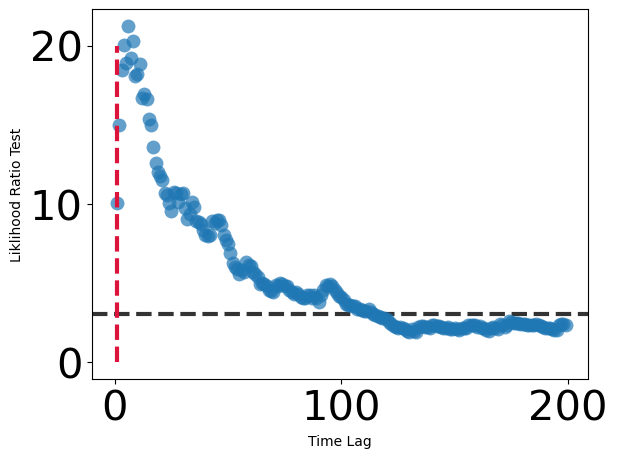

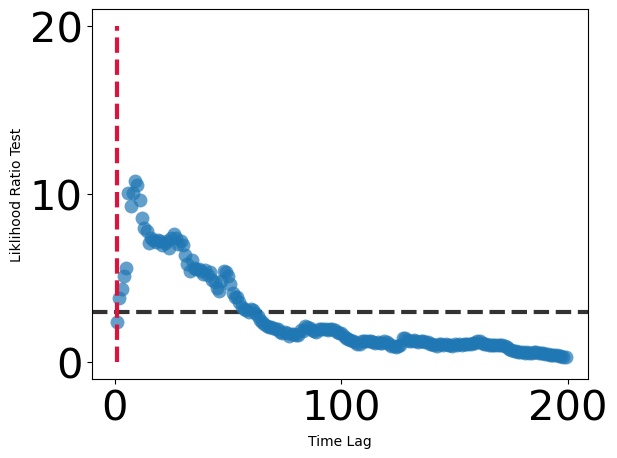

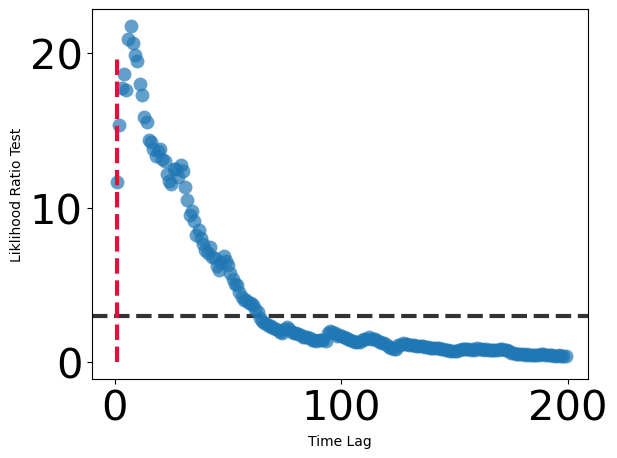

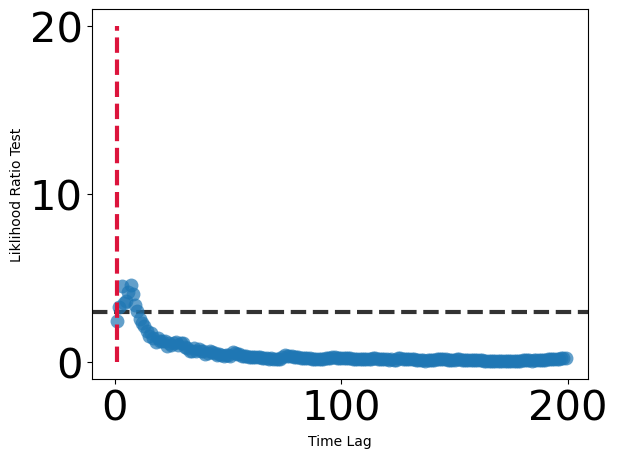

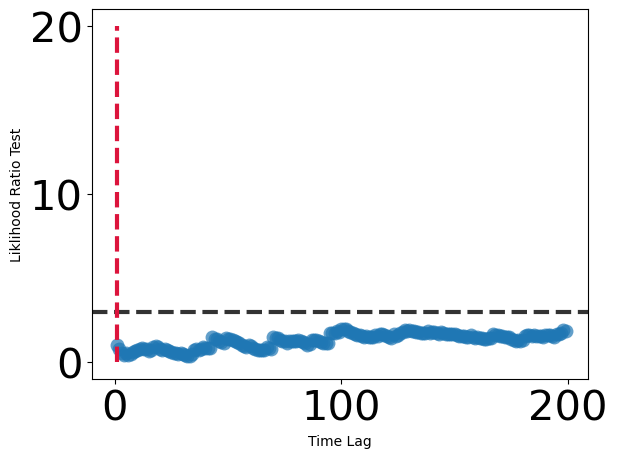

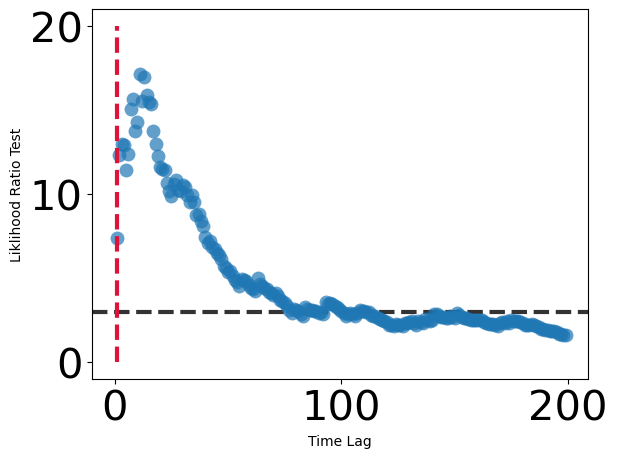

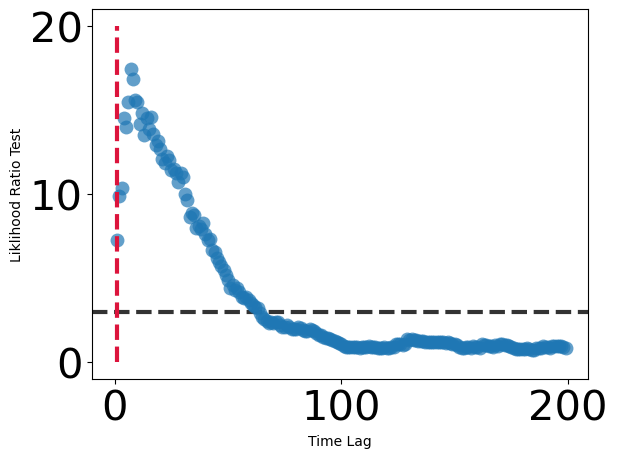

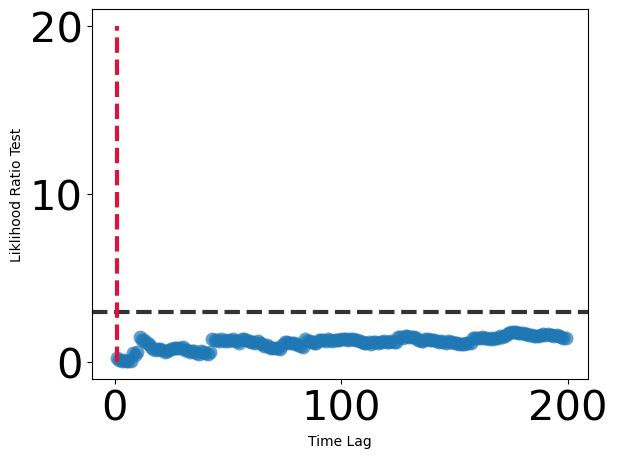

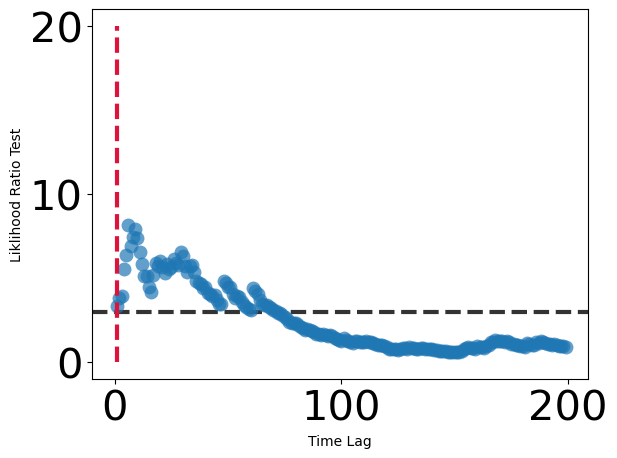

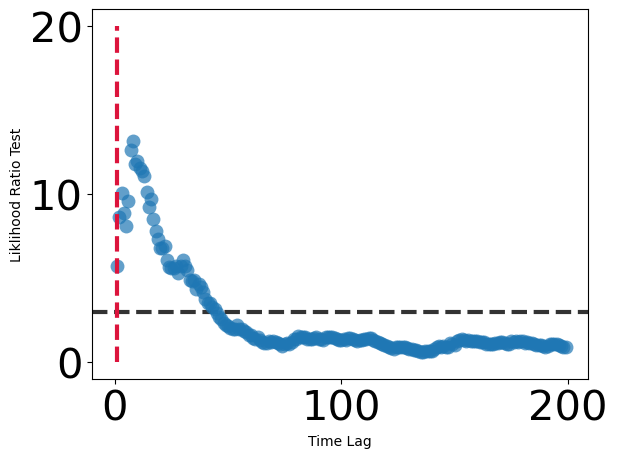

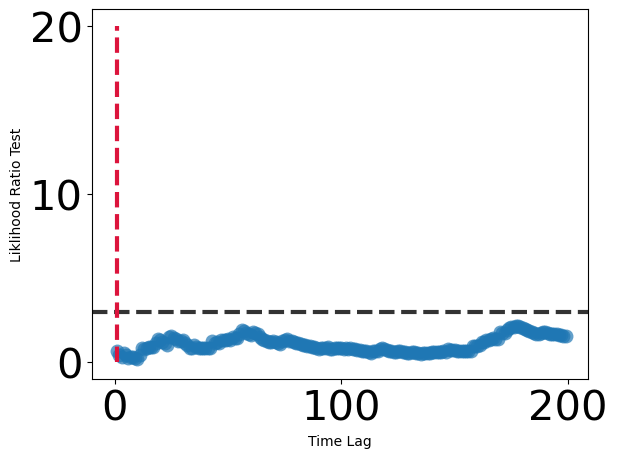

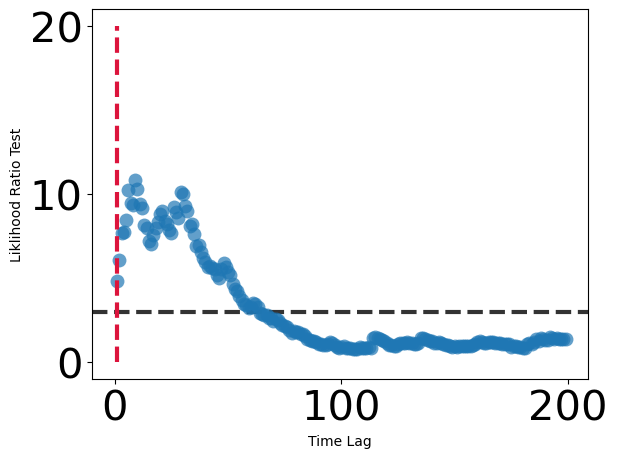

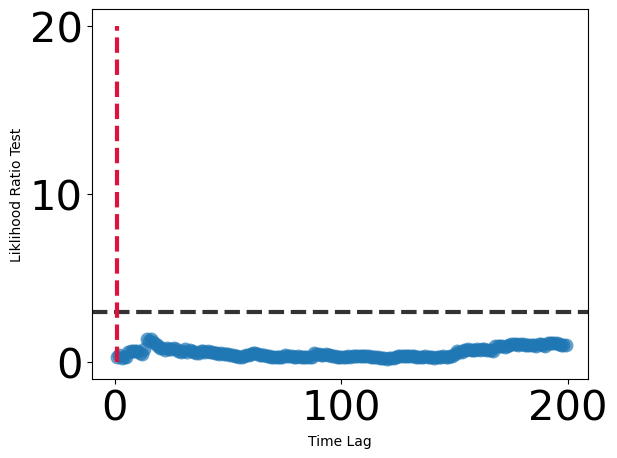

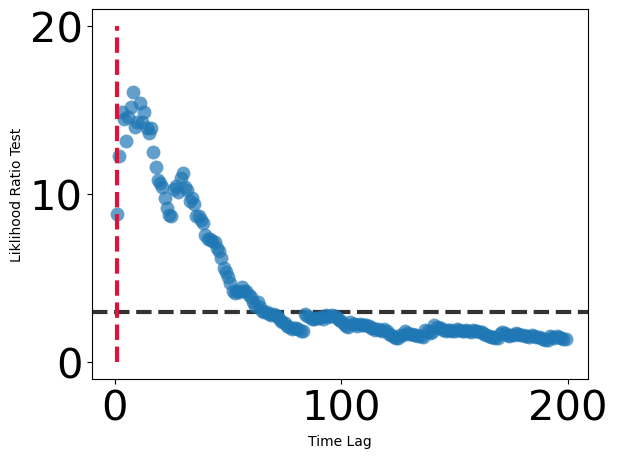

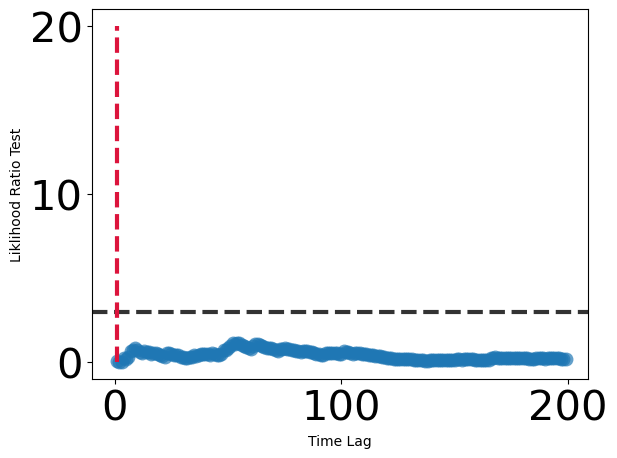

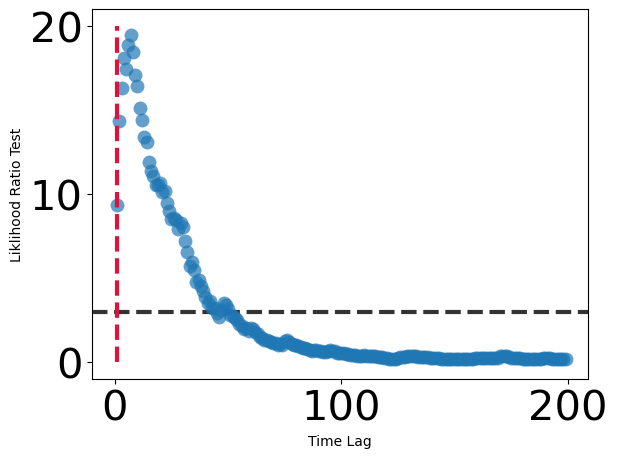

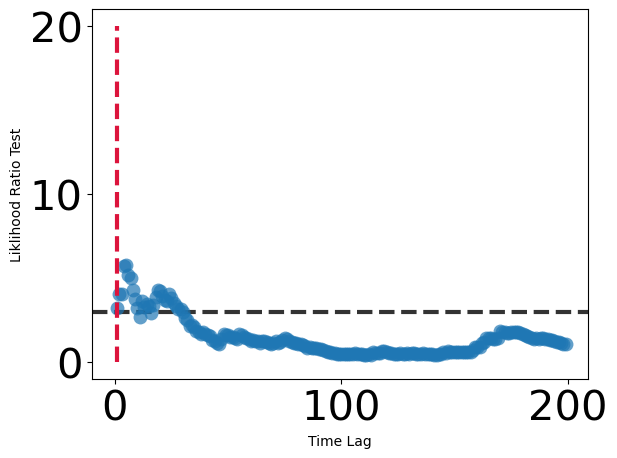

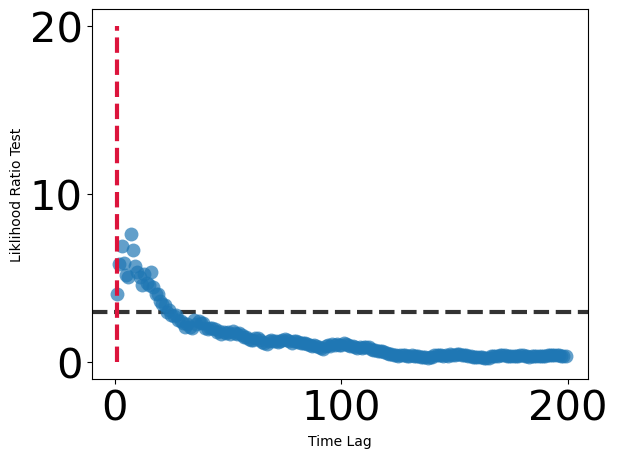

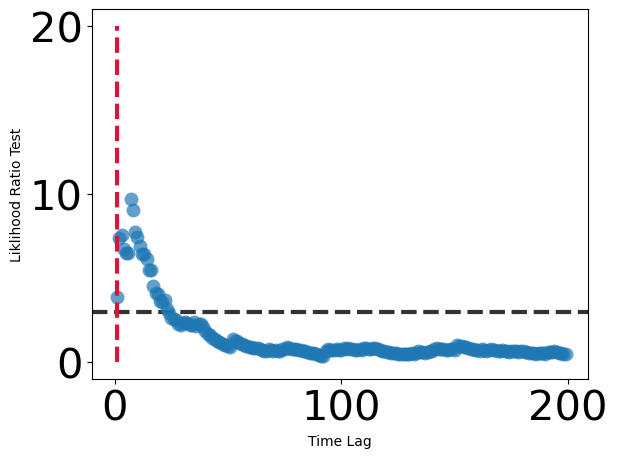

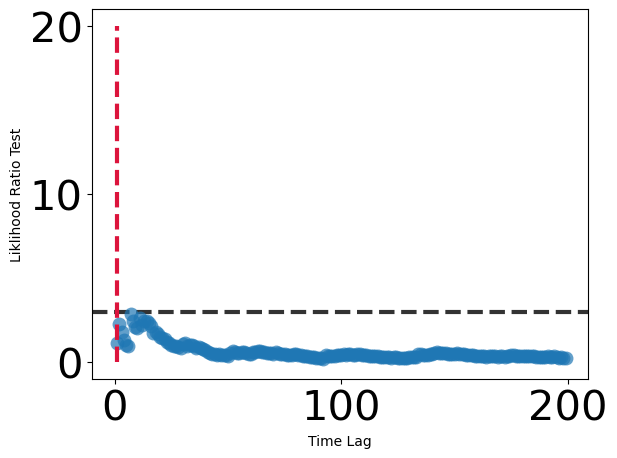

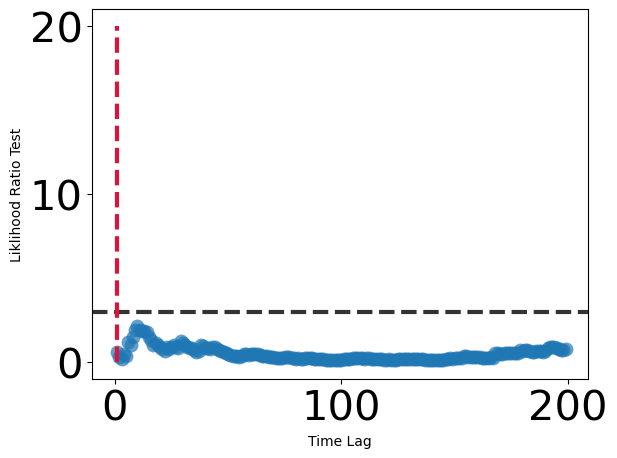

In [31]:
for peak in super_enhancer_peaks:
    subtab =  tab.loc[:, ["ITGA3", peak]].to_numpy()
    gc_res = grangercausalitytests(subtab, 200)
    # pvalues = plot_granger_pvalue(gc_res, range(1, 200), "hair_gene_peak/DLX3_ITGA3_{}_granger.pdf".format(peak), s=50)
    pvalues = plot_granger_pvalue_lt(gc_res, range(1, 200), "hair_gene_peak/SE_peak/DLX3_ITGA3_{}_granger.pdf".format(peak), s=100)

In [16]:
super_enhancer_peaks = ["8225", "10973", "24005",  "68811", "69233","272635"]

['8225', '10973', '24005', '68811', '69233', '272635']

In [95]:
atac_data.var.loc[super_enhancer_peaks, :]

,feature_types,modality,n_cells,chr,start,end
Id,,,,,,
8225,Peaks,Peaks,649,chr11,95118161,95118461
10973,Peaks,Peaks,440,chr11,95113263,95113563
24005,Peaks,Peaks,257,chr11,95097013,95097313
68811,Peaks,Peaks,495,chr11,95118488,95118788
69233,Peaks,Peaks,182,chr11,95106812,95107112
272635,Peaks,Peaks,165,chr11,95117644,95117944


In [ ]:
super_enhancer_peaks_granger = ["8225", "10973", "16804", "24005", "33607", "56344", "68811", "69233","272635"]

In [91]:
sub = atac_data.var.loc[tab.columns[4:-2], :]
sub[(sub["start"]>=95112101)&(sub["end"]<=95112403)]

,feature_types,modality,n_cells,chr,start,end



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8861  , p=0.0271  , df_denom=6432, df_num=1
ssr based chi2 test:   chi2=4.8884  , p=0.0270  , df=1
likelihood ratio test: chi2=4.8865  , p=0.0271  , df=1
parameter F test:         F=4.8861  , p=0.0271  , df_denom=6432, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1290  , p=0.0438  , df_denom=6429, df_num=2
ssr based chi2 test:   chi2=6.2628  , p=0.0437  , df=2
likelihood ratio test: chi2=6.2597  , p=0.0437  , df=2
parameter F test:         F=3.1290  , p=0.0438  , df_denom=6429, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.8829  , p=0.0022  , df_denom=6426, df_num=3
ssr based chi2 test:   chi2=14.6645 , p=0.0021  , df=3
likelihood ratio test: chi2=14.6478 , p=0.0021  , df=3
parameter F test:         F=4.8829  , p=0.0022  , df_denom=6426, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.0579  , p=0.

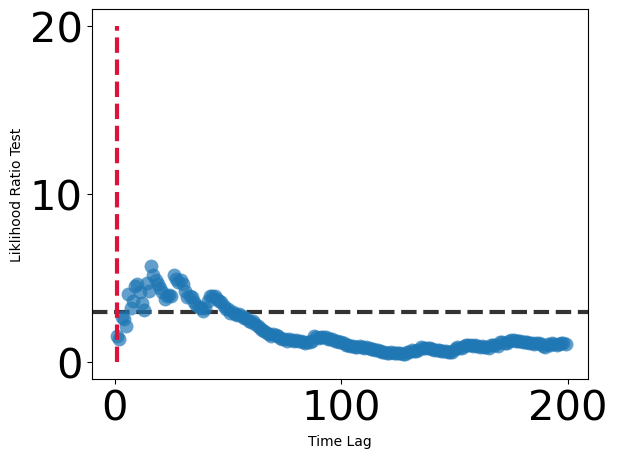

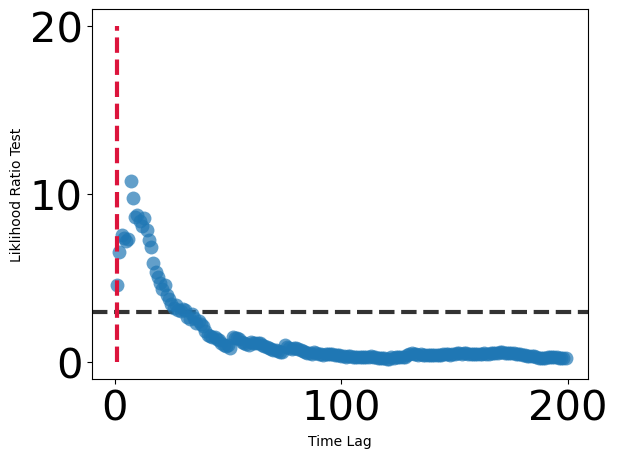

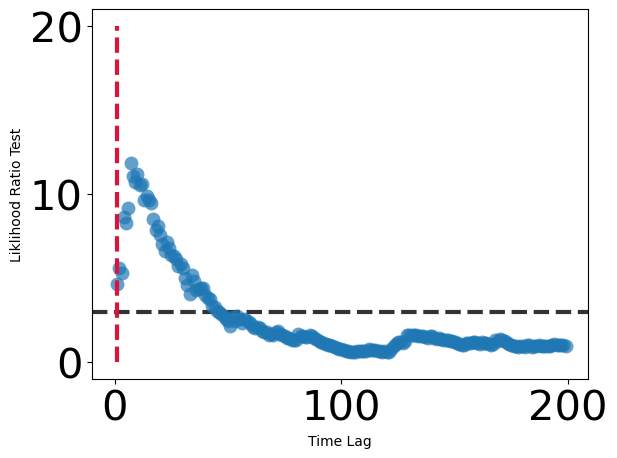

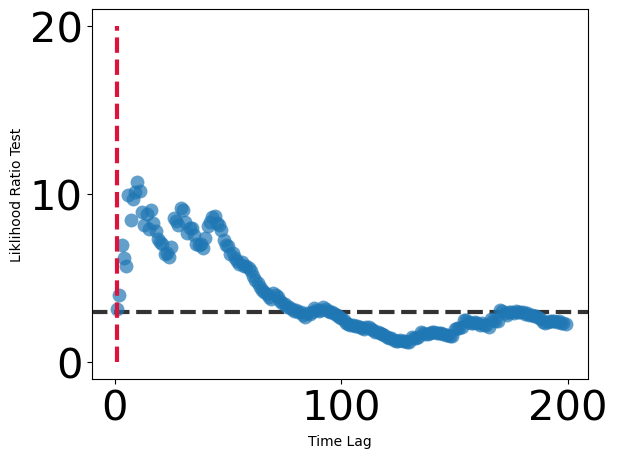

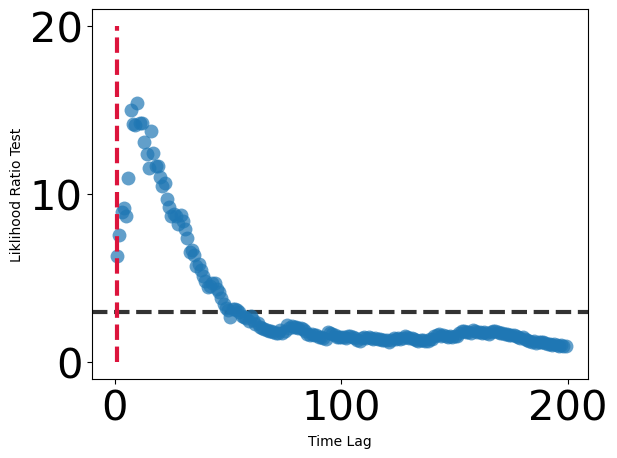

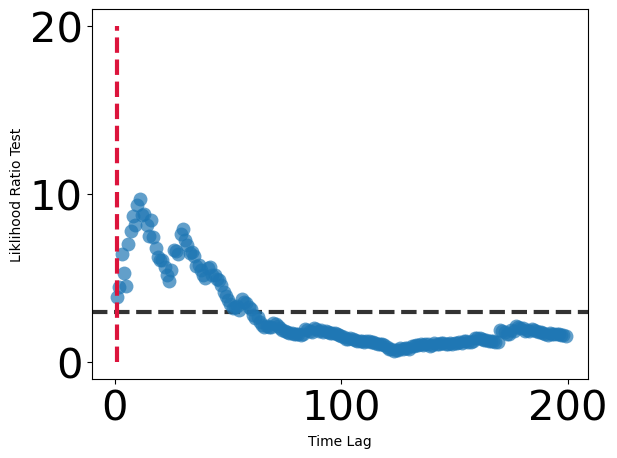

In [85]:
for peak in super_enhancer_peaks:
    subtab =  tab.loc[:, ["ITGA3", peak]].to_numpy()
    gc_res = grangercausalitytests(subtab, 200)
    # pvalues = plot_granger_pvalue(gc_res, range(1, 200), "hair_gene_peak/DLX3_ITGA3_{}_granger.pdf".format(peak), s=50)
    pvalues = plot_granger_pvalue_lt(gc_res, range(1, 200), "hair_gene_peak/DLX3_ITGA3_{}_granger.pdf".format(peak), s=100)

In [30]:
get_gene_peak_timeseries_pairs("PTCH2", rp_genes, atac_data, rna_data, litemodel, decay_period_p=1, time="latent_time")

TENM2


,EIF2B3,ST3GAL3,16249,36732,68669,70728,73011,98003,109097,109098,118984,163641,262290,309645,peak_sum,latent_time
2369,0.000239,0.000733,0.159186,0.098607,0.069803,0.037645,0.050777,0.030668,0.051805,0.043221,0.044660,0.019820,0.042945,0.024040,0.673176,0.000000
6375,0.000410,0.000858,0.239539,0.216344,0.123582,0.117122,0.092667,0.076260,0.071162,0.107227,0.081126,0.035193,0.110011,0.042022,1.312256,0.013742
4223,0.000275,0.000604,0.077404,0.051984,0.040526,0.030072,0.040545,0.029704,0.047086,0.029946,0.038728,0.020006,0.037933,0.045111,0.489046,0.019982
197,0.000461,0.000586,0.243551,0.158817,0.057470,0.093373,0.115520,0.069352,0.062166,0.078108,0.059658,0.043120,0.068085,0.032316,1.081534,0.021351
339,0.000121,0.000734,0.164013,0.061372,0.007354,0.025520,0.165659,0.005720,0.037992,0.050497,0.006650,0.014807,0.020019,0.003934,0.563537,0.022359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4509,0.000509,0.000294,0.133257,0.147648,0.122043,0.015475,0.013285,0.006703,0.032621,0.009250,0.024520,0.007293,0.031184,0.012691,0.555970,0.972302
4691,0.000752,0.000386,0.097256,0.128725,0.095126,0.020766,0.020937,0.020127,0.051599,0.021671,0.037018,0.017539,0.068955,0.033049,0.612767,0.978093
4037,0.000586,0.000529,0.113694,0.096661,0.046137,0.018395,0.028022,0.019648,0.056155,0.017993,0.028701,0.021706,0.040495,0.027452,0.515058,0.988974
4499,0.000496,0.000411,0.091074,0.103078,0.056743,0.018521,0.023761,0.021895,0.059362,0.019958,0.031905,0.018909,0.050757,0.041466,0.537430,0.992354


In [29]:
# 10973

atac_data.var.loc["10973", :]

feature_types       Peaks
modality            Peaks
n_cells               440
chr                 chr11
start            95113263
end              95113563
Name: 10973, dtype: object

In [68]:
tab.loc[:,["COL1A1", "ITGA3", "KAT7"]] *=1e3


In [33]:
# tab = get_gene_peak_timeseries_pairs("PTCH2", rp_genes, atac_data, rna_data, litemodel, decay_period_p=0.1, decay_period_g=300, time="latent_time")
# tab 
#SEMA4B	VPS33B	2251	35096	291563	peak_sum	latent_time
subtab =  tab.loc[:, ["ST3GAL3", "16249"]].to_numpy()
subtab

array([[0.0007329 , 0.15918621],
       [0.00085796, 0.23953882],
       [0.00060396, 0.07740448],
       ...,
       [0.00052939, 0.11369374],
       [0.00041054, 0.09107351],
       [0.00057992, 0.15690532]], dtype=float32)

In [36]:
atac_data.var.loc["16249"]

feature_types        Peaks
modality             Peaks
n_cells                426
chr                   chr4
start            117095861
end              117096161
Name: 16249, dtype: object


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=47.6320 , p=0.0000  , df_denom=6432, df_num=1
ssr based chi2 test:   chi2=47.6542 , p=0.0000  , df=1
likelihood ratio test: chi2=47.4786 , p=0.0000  , df=1
parameter F test:         F=47.6320 , p=0.0000  , df_denom=6432, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=41.7356 , p=0.0000  , df_denom=6429, df_num=2
ssr based chi2 test:   chi2=83.5362 , p=0.0000  , df=2
likelihood ratio test: chi2=82.9985 , p=0.0000  , df=2
parameter F test:         F=41.7356 , p=0.0000  , df_denom=6429, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=30.2509 , p=0.0000  , df_denom=6426, df_num=3
ssr based chi2 test:   chi2=90.8516 , p=0.0000  , df=3
likelihood ratio test: chi2=90.2160 , p=0.0000  , df=3
parameter F test:         F=30.2509 , p=0.0000  , df_denom=6426, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=25.2728 , p=0.

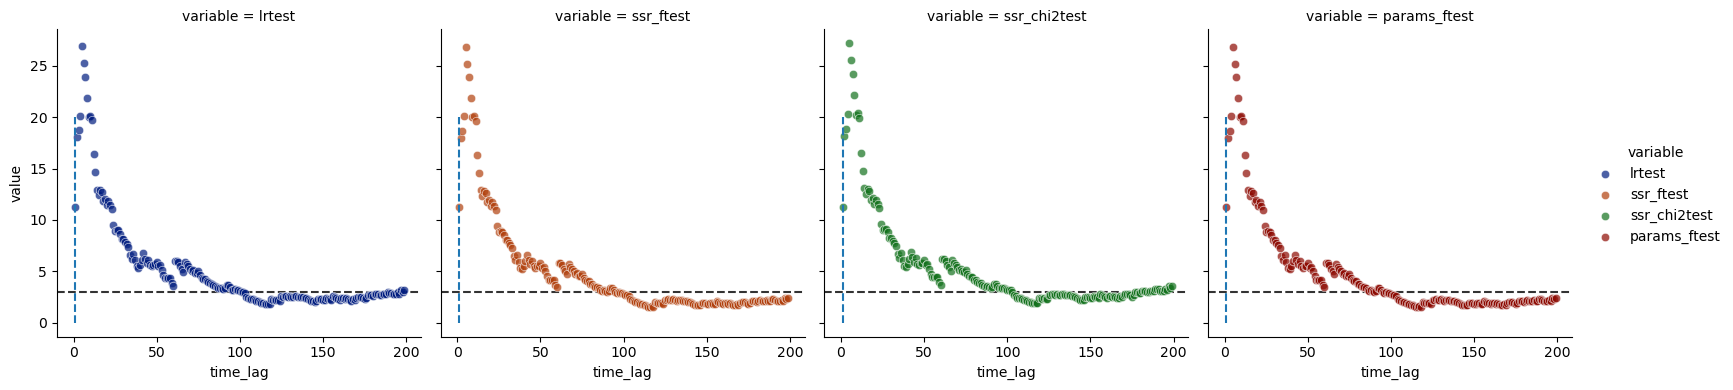

In [34]:
gc_res = grangercausalitytests(subtab, 200)
pvalues = plot_granger_pvalue(gc_res, range(1, 200))

In [74]:
gc_res = grangercausalitytests(subtab, 200)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.7480 , p=0.0000  , df_denom=6432, df_num=1
ssr based chi2 test:   chi2=17.7563 , p=0.0000  , df=1
likelihood ratio test: chi2=17.7318 , p=0.0000  , df=1
parameter F test:         F=17.7480 , p=0.0000  , df_denom=6432, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=15.0831 , p=0.0000  , df_denom=6429, df_num=2
ssr based chi2 test:   chi2=30.1896 , p=0.0000  , df=2
likelihood ratio test: chi2=30.1190 , p=0.0000  , df=2
parameter F test:         F=15.0831 , p=0.0000  , df_denom=6429, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=12.7000 , p=0.0000  , df_denom=6426, df_num=3
ssr based chi2 test:   chi2=38.1416 , p=0.0000  , df=3
likelihood ratio test: chi2=38.0289 , p=0.0000  , df=3
parameter F test:         F=12.7000 , p=0.0000  , df_denom=6426, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=10.0654 , p=0.

,lrtest,ssr_ftest,ssr_chi2test,params_ftest,time_lag
0,4.594596,4.592395,4.600179,4.592395,1
1,6.540250,6.535167,6.555582,6.535167,2
2,7.554882,7.546746,7.578728,7.546746,3
3,7.403459,7.393117,7.429491,7.393117,4
4,7.181720,7.169240,7.209211,7.169240,5
...,...,...,...,...,...
194,0.265195,0.143258,0.316564,0.143258,195
195,0.224827,0.117427,0.270225,0.117427,196
196,0.257928,0.137191,0.309023,0.137191,197
197,0.244053,0.127867,0.293353,0.127867,198


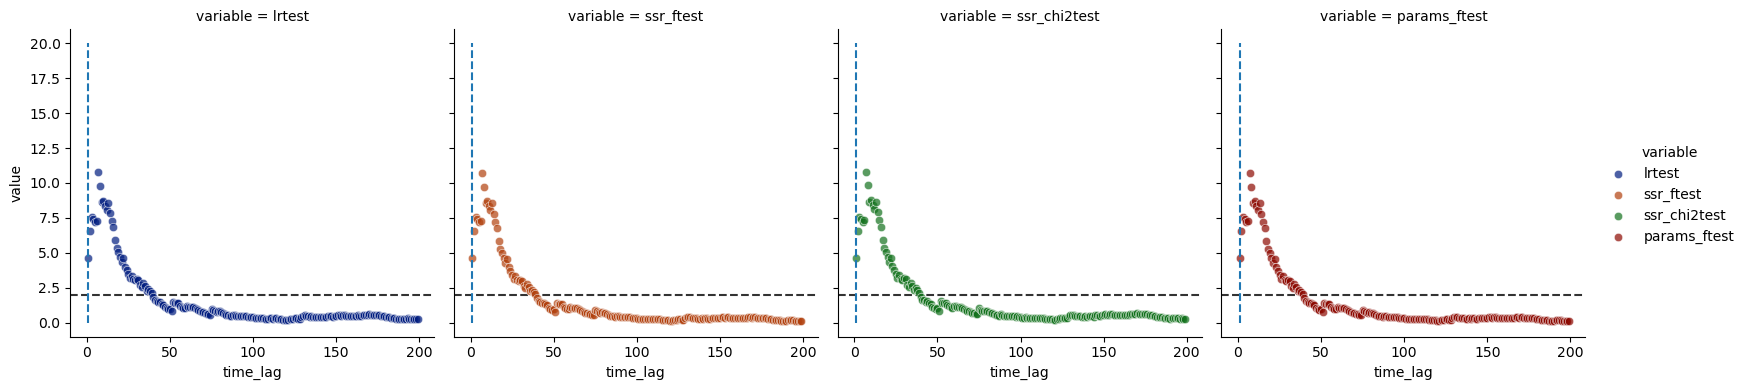

In [85]:
pvalues = plot_granger_pvalue(gc_res, range(1, 200))
pvalues

In [79]:
tab = get_gene_peak_timeseries_pairs("MT1", rp_genes, atac_data, rna_data, litemodel, decay_period_p=.01, time="latent_time")
tab

TENM2


,MT2,MT2,1306,peak_sum,latent_time
2369,0.001145,0.001145,0.388229,0.388229,0.000000
6375,0.000541,0.000541,0.382077,0.382077,0.013742
4223,0.000818,0.000818,0.324661,0.324661,0.019982
197,0.002291,0.002291,0.343404,0.343404,0.021351
339,0.000759,0.000759,0.396178,0.396178,0.022359
...,...,...,...,...,...
4509,0.000332,0.000332,0.346559,0.346559,0.972302
4691,0.000262,0.000262,0.281496,0.281496,0.978093
4037,0.001400,0.001400,0.330451,0.330451,0.988974
4499,0.000354,0.000354,0.310946,0.310946,0.992354


In [80]:
tab = tab.iloc[:, [0,2,3,4]]


In [81]:
tab.loc[:,"MT2"]*=1e3

In [82]:
subtab= tab.loc[:, ["MT2", "peak_sum"]].to_numpy()
gc_res2 = grangercausalitytests(subtab, range(1,200))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1764  , p=0.0130  , df_denom=6432, df_num=1
ssr based chi2 test:   chi2=6.1793  , p=0.0129  , df=1
likelihood ratio test: chi2=6.1764  , p=0.0129  , df=1
parameter F test:         F=6.1764  , p=0.0130  , df_denom=6432, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.8125  , p=0.0030  , df_denom=6429, df_num=2
ssr based chi2 test:   chi2=11.6340 , p=0.0030  , df=2
likelihood ratio test: chi2=11.6235 , p=0.0030  , df=2
parameter F test:         F=5.8125  , p=0.0030  , df_denom=6429, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.0727  , p=0.0266  , df_denom=6426, df_num=3
ssr based chi2 test:   chi2=9.2281  , p=0.0264  , df=3
likelihood ratio test: chi2=9.2215  , p=0.0265  , df=3
parameter F test:         F=3.0727  , p=0.0266  , df_denom=6426, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.3940  , p=0.

,lrtest,ssr_ftest,ssr_chi2test,params_ftest,time_lag
0,1.887835,1.887010,1.888563,1.887010,1
1,2.524008,2.522047,2.526290,2.522047,2
2,1.576975,1.575135,1.578281,1.575135,3
3,2.057452,2.054255,2.060168,2.054255,4
4,1.982771,1.978806,1.985902,1.978806,5
...,...,...,...,...,...
194,0.270982,0.146920,0.323243,0.146920,195
195,0.302822,0.166435,0.360390,0.166435,196
196,0.357485,0.201068,0.423677,0.201068,197
197,0.362489,0.203364,0.429961,0.203364,198


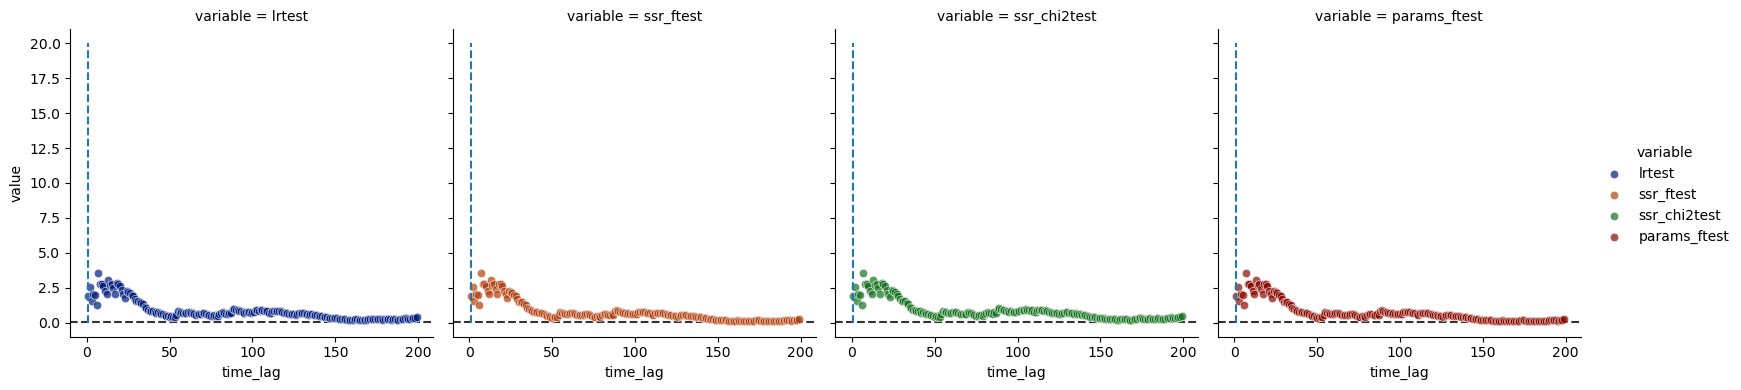

In [83]:
pvalues = plot_granger_pvalue(gc_res2, range(1,200))
pvalues